REQUIRED LIBRARY

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re,json,nltk

import tensorflow as tf
import tensorflow_hub as hub


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.preprocessing.text import Tokenizer

stopwords_list = '/content/drive/MyDrive/DATAset/stopwords-bn.txt'
path = '/content/drive/MyDrive/DATAset/sentiNOB/'



DATASET

In [2]:
data = pd.read_csv('/content/drive/MyDrive/DATAset/sentiNOB/Train.csv',encoding='UTF-8')
data_test = pd.read_csv('/content/drive/MyDrive/DATAset/sentiNOB/Test.csv',encoding='UTF-8')
data_val = pd.read_csv('/content/drive/MyDrive/DATAset/sentiNOB/Test.csv',encoding='UTF-8')

data_val.head(10)

,Data,Label
0,"স্বাস্থ্যবান হতে চাই , আমি বয়সের তুলনায় অনেক ব...",0
1,ভাইয়া নতুন ভিডিও আসে না কেন,0
2,সৌরভ গাঙ্গুলী ছাড়া দাদাগিরি কখনো জমে উঠত না,0
3,ক্রিকেট কে বাচাতে হলে পাপকে অতিশিগ্রিই তাকেও গ...,2
4,আমিতো সেই ঝালপ্রিয়ো মানুষ,1
5,টেকনিশিয়ান রা খাবার খাইয়ে আবার হজম করিয়ে দিবে ...,2
6,অন্য সব ইউনিভার্সিটিতে এর চেয়ে ভয়াবহ অবস্থা । ...,2
7,আর অভাবে কত আসলে সরকারের উচিৎ ভালো কোনো পদক্ষে...,1
8,এই সব কিছু হবে কেন কেন এরকম অত্যাচার আমি মনে ক...,2
9,সব কিছুই দরলাম ভালো পুলিশ টা অনেক ভালো কিন্তুু...,2


In [3]:
data_test.head()

,Data,Label
0,"স্বাস্থ্যবান হতে চাই , আমি বয়সের তুলনায় অনেক ব...",0
1,ভাইয়া নতুন ভিডিও আসে না কেন,0
2,সৌরভ গাঙ্গুলী ছাড়া দাদাগিরি কখনো জমে উঠত না,0
3,ক্রিকেট কে বাচাতে হলে পাপকে অতিশিগ্রিই তাকেও গ...,2
4,আমিতো সেই ঝালপ্রিয়ো মানুষ,1


DATA CLEANING

In [4]:
# Data cleaning function
def process_comments(Comment): 
    Comment = re.sub('[^\u0980-\u09FF]',' ',str(Comment)) #removing unnecessary punctuation
    return Comment

In [5]:
def remove_bnDigit(Comment): 
    Comment = re.sub('[০-৯]',' ',str(Comment)) #removing unnecessary digit
    return Comment

In [6]:
data['Data'] = data['Data'].apply(remove_bnDigit)
data_test['Data'] = data_test['Data'].apply(remove_bnDigit)
data_val['Data'] = data_val['Data'].apply(remove_bnDigit)

In [7]:
# Apply the function into the dataframe
data['Data'] = data['Data'].apply(process_comments)  
data_test['Data'] = data_test['Data'].apply(process_comments) 
data_val['Data'] = data_val['Data'].apply(process_comments) 


# print some cleaned reviews from the dataset
sample_data = [10,100,25,854,966,1500,1589,1700,2000,2500,4000,4500]
for i in sample_data:
     print('Original:\n',data.Data[i],'\nCleaned:\n',
           data.Data[i],'\n','Sentiment: ',data.Label[i],'\n')

Original:
 লেসবো মেয়েটার ফ্রেন্ড টা অনেক কিউট  
Cleaned:
 লেসবো মেয়েটার ফ্রেন্ড টা অনেক কিউট  
 Sentiment:  2 

Original:
 ভর দুপুরে এত খাবার দেখে ভীষণ লোভ লাগল দাদা   দিদি কে দেখতে পেলে ভালো লাগত  
Cleaned:
 ভর দুপুরে এত খাবার দেখে ভীষণ লোভ লাগল দাদা   দিদি কে দেখতে পেলে ভালো লাগত  
 Sentiment:  1 

Original:
 ভালো লাগল বিউটি বোডিং দেখে   আমি শুনেছি বাংলাদেশ এর সাধীনতা র ইতিহাস এর সাথে একাত্ত্ব এই বোডিং হাউস 
Cleaned:
 ভালো লাগল বিউটি বোডিং দেখে   আমি শুনেছি বাংলাদেশ এর সাধীনতা র ইতিহাস এর সাথে একাত্ত্ব এই বোডিং হাউস 
 Sentiment:  1 

Original:
 আল্লাহ কে ভয় করা উচিত   অাল্লাহ চাইলে এর চেয়েও ভয়াবহ ভাবে পৃথিবী ধ্বংস করতে পারেন   এটা নমুনা মাত্র  
Cleaned:
 আল্লাহ কে ভয় করা উচিত   অাল্লাহ চাইলে এর চেয়েও ভয়াবহ ভাবে পৃথিবী ধ্বংস করতে পারেন   এটা নমুনা মাত্র  
 Sentiment:  1 

Original:
 বাংলাদেশের কি গুন   শুধু নিউজিই হয়   এত খুন ধর্ষণ হয় একটারও তো ফাঁসি হয় না   বলতে লজ্জা লাগে আমাদের দেশটা হয়ে যাচ্ছে মেরুদন্ডহীন দেশ  
Cleaned:
 বাংলাদেশের কি গুন   শুধু নিউজিই হয়   এত খুন ধর্ষণ হয় এ

In [8]:
data_val.head()

,Data,Label
0,স্বাস্থ্যবান হতে চাই আমি বয়সের তুলনায় অনেক ব...,0
1,ভাইয়া নতুন ভিডিও আসে না কেন,0
2,সৌরভ গাঙ্গুলী ছাড়া দাদাগিরি কখনো জমে উঠত না,0
3,ক্রিকেট কে বাচাতে হলে পাপকে অতিশিগ্রিই তাকেও গ...,2
4,আমিতো সেই ঝালপ্রিয়ো মানুষ,1


In [9]:
data.rename(columns={"Data": "review"}, inplace=True)
data_test.rename(columns={"Data": "review"}, inplace=True)
data_val.rename(columns={"Data": "review"}, inplace=True)

In [10]:
data.drop(data.index[(data["Label"] == "conflict")],axis=0,inplace=True)

len(data)

12575

In [11]:
data['Label'].unique()

array([1, 2, 0])

In [12]:
data.drop_duplicates(subset="review", keep="first", inplace=True)
len(data)

11984

In [13]:
data.head()

,review,Label
0,মুগ্ধ হয়ে গেলাম মামু আর তোমায় কি কমু বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ...,0


EDA

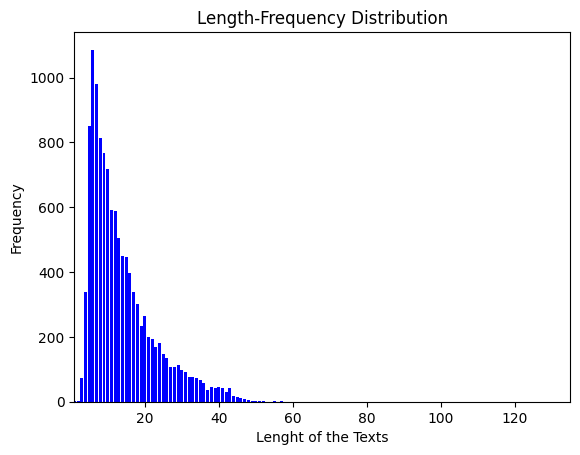

Maximum Length of a review: 57
Minimum Length of a review: 0
Average Length of a reviews: 14.0


In [14]:
# Calculate the Review of each of the Review
data['ReviewLength'] = data.review.apply(lambda x:len(x.split()))
frequency = dict()
for i in data.ReviewLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a review: {max(data.ReviewLength)}")
print(f"Minimum Length of a review: {min(data.ReviewLength)}")
print(f"Average Length of a reviews: {round(np.mean(data.ReviewLength),0)}")

In [15]:
# Length of each Reveiws
data['length'] = data['review'].apply(lambda x:len(x.split()))
# Remove the reviews with least words
data = data.loc[data.length>3]
data = data.loc[data.length<51]
data = data.reset_index(drop = True)


In [16]:
len(data)

11898

REMOVING STOPWORDS

In [17]:

from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('bengali'))

def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
# data['review'] = data['review'].apply(remove_stopwords)

In [19]:
data.drop("ReviewLength",axis=1,inplace=True)
data.drop("length",axis=1,inplace=True)


**DATA SCALING**

In [20]:
print("Total Reviews:",len(data),
      "\nTotal Positive Reviews:",len(data[data.Label =='1']),
      "\nTotal Negative Reviews:",len(data[data.Label=='2']),
      "\nTotal Neutral Reviews:",len(data[data.Label =='0']))

Total Reviews: 11898 
Total Positive Reviews: 0 
Total Negative Reviews: 0 
Total Neutral Reviews: 0


In [21]:
# data_neu = data[data['Label']=='0']
# data_neu.shape

In [22]:
# data_neg = data[data['Label']=='2']
# data_neg.shape

In [23]:
# data_pos = data[data['Label']=='1']
# data_pos.shape

In [24]:
# data_pos_downsampled = data_pos.sample(data_neu.shape[0])
# data_pos_downsampled.shape

In [25]:
# data_neg_downsampled = data_neg.sample(data_neu.shape[0])
# data_neg_downsampled.shape

In [26]:
# data = pd.concat([data_pos_downsampled, data_neu,data_neg_downsampled])
# data.shape

In [27]:
# print("Total Reviews:",len(data),
#       "\nTotal Positive Reviews:",len(data[data.Label =='1']),
#       "\nTotal Negative Reviews:",len(data[data.Label=='2']),
#       "\nTotal Neutral Reviews:",len(data[data.Label =='0']))

In [28]:
data.head(10)

,review,Label
0,মুগ্ধ হয়ে গেলাম মামু আর তোমায় কি কমু বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ...,0
5,যেমন পরীক্ষার রেজাল্টের সময় বিভিন্ন ব্যানি...,0
6,বিশ্বনন্দিত বিশ্ব জয় করা ইসলামের পাখিদের কোরআ...,2
7,সাপ্তাহিক মুসুল্লিদের কথাটাও তুলে ধরলে ভাই চ...,1
8,আমি ভেবেছিলাম গালিগালাজ করে সেরা ছেলে সে গাল...,0
9,তুমি রেপারই হও ডাক্তার হওয়ার দরকার নাই তোমার,0


In [29]:
# # shuffle the DataFrame rows
# data = data.sample(frac = 1).reset_index()

In [30]:
# data.drop("index",axis=1,inplace=True)

In [31]:
# data.head(20)

**BERT IMPLIMENTATION (Sagor)**

In [32]:
# data = data.iloc[:20000] #taking 20,000 row
data.shape

(11898, 2)

In [33]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.3 MB/s eta 0:00:00


In [34]:
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten,Reshape,dot,multiply
from tensorflow.keras.models import Model, Sequential
import keras
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Nadam

In [35]:
#TOKENIZER
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

In [36]:
print(tokenizer.sep_token, tokenizer.sep_token_id)

[SEP] 102


In [37]:
#BERT-MODEL
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('sagorsarker/bangla-bert-base')

Some layers from the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at sagorsarker/bangla-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


**TOKENIZATION**

In [38]:
############################## Sentence Encoding (function) for Transformers 

def bert_encode(data,maximum_length,tokenizer) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(data)):
      encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,
        
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

**MODEL**

In [39]:
#######################################             Model (function) Defination
def create_model(bert_model,max_len):
  input_ids = Input(shape=(max_len,),dtype='int32')
  attention_masks = Input(shape=(max_len,),dtype='int32')
  output = bert_model([input_ids,attention_masks])
  output = output[0] ##  0 for individual word embedding , 1 for sentence embedding
  output = Dropout(0.1)(output)

  output = LSTM(64, return_sequences=True)(output)
  output = LSTM(64)(output)   
  output = Dense(128, activation="relu")(output)

  
  output = Dense(3,activation="softmax")(output) 
  model = Model(inputs = [input_ids,attention_masks],outputs = output)
  return model

TRAIN TEST VALIDATION

In [40]:
# X_train, X_rem, y_train, y_rem = train_test_split(data['review'],data['Label'], train_size=0.8)

In [41]:
# X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [42]:
x_train = data['review']
y_train = data['Label']

x_test = data_test['review']
y_test = data_test['Label']

x_val = data_val['review']
y_val = data_val['Label']

In [43]:
x_val.shape,y_val.shape

((1586,), (1586,))

In [44]:
X_train = list(x_train)
X_test = list(x_test)
X_valid = list(x_val)

In [45]:
y_train = tf.constant(y_train.astype('float32').values)
y_test = tf.constant(y_test.astype('float32').values)
y_valid = tf.constant(y_val.astype('float32').values)

In [46]:
type(y_test)

tensorflow.python.framework.ops.EagerTensor

TOKENIZING TRAIN TEST VALIDATION

In [47]:
train_input_ids,train_attention_masks = bert_encode(X_train,70,tokenizer)
test_input_ids,test_attention_masks = bert_encode(X_test,70,tokenizer)
val_input_ids,val_attention_masks = bert_encode(X_valid,70,tokenizer)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [48]:
test_input_ids

array([[  101,  2132,  7428, ...,     0,     0,     0],
       [  101,  2570,  7724, ...,     0,     0,     0],
       [  101,   100, 41537, ...,     0,     0,     0],
       ...,
       [  101,  4600, 14117, ...,     0,     0,     0],
       [  101,  5589, 11977, ...,     0,     0,     0],
       [  101,  2045, 12755, ...,     0,     0,     0]])

CALLBACK

In [49]:

from keras.callbacks import ModelCheckpoint,EarlyStopping
filepath = path + "sentiNOBckpt.h5"

checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor='val_accuracy', 
                                             verbose=1, 
                                             save_best_only=True,
                                             save_weights_only=True, 
                                             mode='max' )


early_stop = EarlyStopping(monitor='val_accuracy',patience=3,verbose=1)

callbacks_list = [checkpoint,early_stop]

In [50]:
keras.backend.clear_session()
# 3e-4, 1e-4, 5e-5, 3e-5,1e-5
model = create_model(bert_model,70)
model.compile(Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  164396544   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                            

In [51]:
  model.fit([train_input_ids,train_attention_masks],
            y_train,
            validation_data=([val_input_ids,val_attention_masks], y_valid),
            epochs=20,
            batch_size=16, 
            callbacks = callbacks_list,
          )

Epoch 1/20


UnknownError: ignored

SAVING AND LOADING MODEL

In [ ]:
# from tensorflow.keras.models import load_model
# model.save(model_path+'banglaSentiModelSakib.h5')

EVALUATING MODEL

In [ ]:
model.evaluate([test_input_ids,test_attention_masks], y_test)

In [ ]:
y_predicted = model.predict([test_input_ids,test_attention_masks])

In [ ]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

In [ ]:
y_predicted_value = []
for i in y_predicted:
  max_ind = argmax(i)
  y_predicted_value.append(max_ind)


In [ ]:
cm = confusion_matrix(y_test, y_predicted_value)
cm 

In [ ]:

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted_value))

***##########  Predicting using the model  ############***

In [ ]:
def model_giving_output(text_input):
  text = text_input
  text_input_ids,text_attention_masks = bert_encode(text,50,tokenizer)
  text_predicted = model.predict([text_input_ids,text_attention_masks])
  max_ind = argmax(text_predicted[0])
  if max_ind == 0:
    print("This is a 'Neutral' statement")
  elif max_ind == 1:
    print("This is a 'Positive' statement")
  else:
    print("This is a 'Negative' statement")
  print(text_predicted[0])

Enter a text to find the sentiment in #model_giving_output() function

In [ ]:
model_giving_output(["পরিষেবা খারাপ ছিল না"])

MACHINE LEARNING IMPLIMENTATION

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
lr_model = LogisticRegressionCV(class_weight='balanced', max_iter=1000)
dt_model = DecisionTreeClassifier(class_weight='balanced')
rf_model = RandomForestClassifier(class_weight='balanced')
mnb_model = MultinomialNB()
svm_model = SVC(class_weight='balanced')
knn_model = KNeighborsClassifier()
ada_model = AdaBoostClassifier()
model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes', 'SVM', 'KNN', 'AdaBoost']
ml_models = [lr_model,dt_model,rf_model,mnb_model, svm_model, knn_model, ada_model]

In [ ]:
def model_train(model, train_data, train_labels):
  pipe = Pipeline([
        ('FE', TfidfVectorizer(ngram_range=(1,2), use_idf = True, tokenizer=lambda x: x.split(), max_features=20000)),  
        ('Transformer', TfidfTransformer()),  
        ('M', model)
    ])
  pipe.fit(train_data, train_labels)
  return pipe



In [ ]:
# trained_ml_models = []
# for i in ml_models:
#     tt = model_train(i,X_train, y_train)
#     trained_ml_models.append(tt)

In [ ]:
pr_list = []
re_list = []
f1_list = []

def print_results(md, x_test, y_test, name):
    
    pred_y = md.predict(x_test)
    true, pred = y_test, pred_y

    pr_list.append((round(precision_score(y_test, pred_y, average='weighted'),4)*100)) 
    re_list.append((round(recall_score(y_test, pred_y, average='weighted'),4)*100))
    f1_list.append((round(f1_score(y_test, pred_y, average='weighted'),4)*100))



In [ ]:
# for i in range(len(trained_ml_models)):
#     md = trained_ml_models[i]
#     name = model_names[i]
#     print_results(md, X_test, y_test, name)

# performance_matrix = pd.DataFrame({'Precision':pr_list,
#                                    'Recall':re_list,'F1 Score':f1_list},
#                                   index =model_names)
# performance_matrix